# Real Face Recognision Task
Goal of this notebook is to create model for predicting either if picture is real or deepfaked.

In [1]:
# few imports 
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from matplotlib import pyplot as plt

# importing and polishing data

In [2]:
IMG_SIZE = 200
BATCH_SIZE = 24
NUM_EPOCHS = 10

In [3]:
# useful functions

def process_image(image_path,img_size=IMG_SIZE):
    '''
    Function takes as an input a string called image_path and optionally img_size,
    it gets an image from the path, 
    turning it into a tensor and resizing it to the square, img_size x img_size.
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3) # turning into a tensor
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[img_size,img_size]) # resizing
    return image

# we are using this function in order to do mini batching
def get_tuples(image_path,label):
    """
    returns (image,label) tuples,
    where label is 0 when image is fake and 1 when it's real
    """
    image = process_image(image_path,IMG_SIZE)
    
    return (image,label)

def get_batch(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X - filepath) and label (y - labels) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    side note: it's easier to shuffle filepaths rather than whole images
    """
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # every filepath as new example
        data_batch = data.map(process_image).batch(BATCH_SIZE) # from filename to image, then get a batch
        return data_batch
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch = data.map(get_tuples).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data batches...")
        
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        
        # shuffling pathnames and labels is far easier than shuffling images
        data = data.shuffle(buffer_size=len(X))
        
        # get (image,label) tuples
        data = data.map(get_tuples)
        
        # Turning into batch
        data_batch = data.batch(BATCH_SIZE)
        
        return data_batch

In [4]:
# import the data
import os
# training data
folder_path = './train'
X_train,y_train = [],[]

for filename in os.listdir(folder_path+'/fake'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/fake', filename)
        X_train.append(image_path)
        y_train.append(0)
        
for filename in os.listdir(folder_path+'/real'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/real', filename)
        X_train.append(image_path)
        y_train.append(1)

# validation data
folder_path = './valid'
X_valid,y_valid = [],[]

for filename in os.listdir(folder_path+'/fake'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/fake', filename)
        X_valid.append(image_path)
        y_valid.append(0)
        
for filename in os.listdir(folder_path+'/real'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/real', filename)
        X_valid.append(image_path)
        y_valid.append(1)

# test data
folder_path = './test'
X_test,y_test = [],[]

for filename in os.listdir(folder_path+'/fake'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/fake', filename)
        X_test.append(image_path)
        y_test.append(0)
        
for filename in os.listdir(folder_path+'/real'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path+'/real', filename)
        X_test.append(image_path)
        y_test.append(1)

# visualising data

3 fakes 


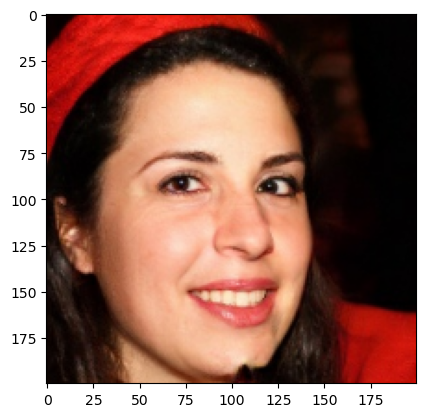

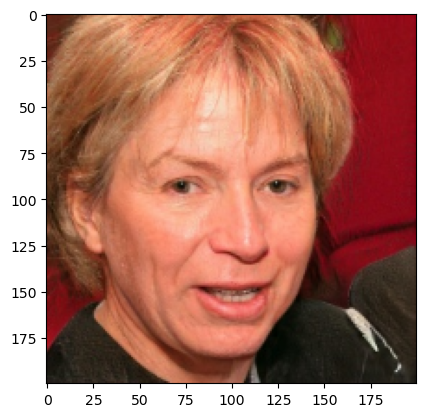

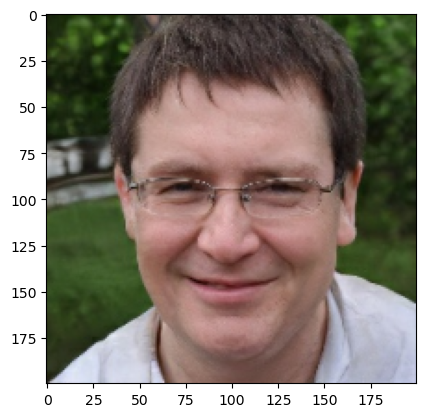

In [5]:
print("3 fakes \n")
plt.imshow(process_image(X_train[0]))
plt.show()
plt.imshow(process_image(X_train[1]))
plt.show()
plt.imshow(process_image(X_train[2]))
plt.show()

3 real faces 


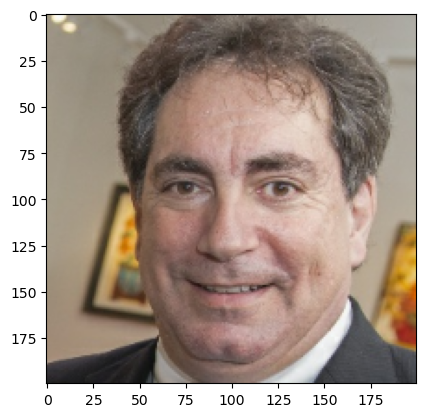

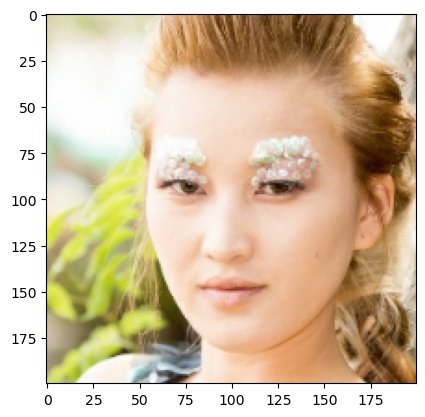

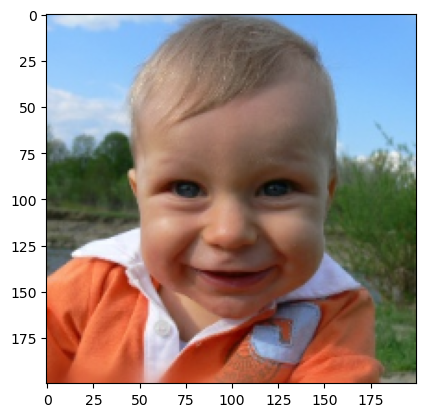

In [6]:
print("3 real faces \n")
plt.imshow(process_image(X_train[-1]))
plt.show()
plt.imshow(process_image(X_train[-2]))
plt.show()
plt.imshow(process_image(X_train[-3]))
plt.show()

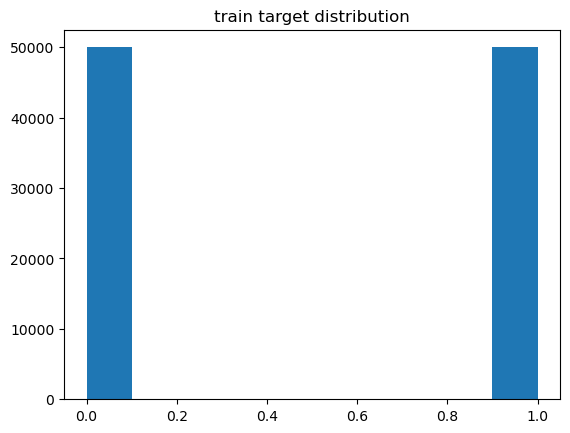

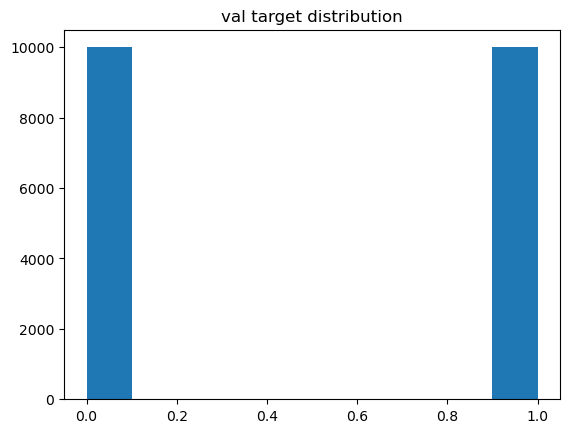

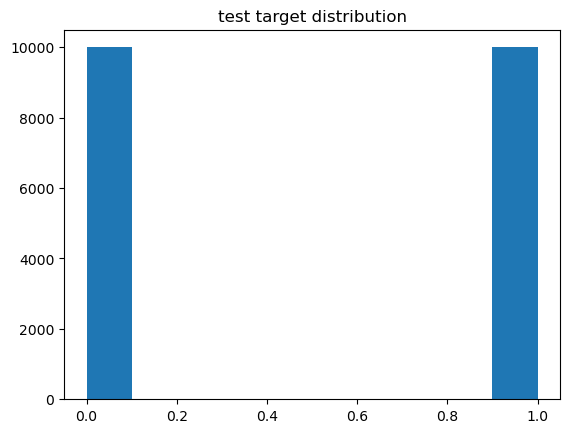

In [7]:
plt.hist(y_train)
plt.title("train target distribution")
plt.show()
plt.hist(y_valid)
plt.title("val target distribution")
plt.show()
plt.hist(y_test)
plt.title("test target distribution")
plt.show()

# modelling

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D,Conv2D,Dense,Flatten,Dropout,Input

model = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5), # 50% of nodes will be deactivated in order to regularize the model
    Dense(256,activation='relu'),
    Dense(1,activation='sigmoid')
])

In [9]:
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(optimizer='adam',loss=BinaryCrossentropy(),metrics=['accuracy','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

In [10]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping

callback_one = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)

In [11]:
def plot_history(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,acc,label='Training accuracy')
    plt.plot(epochs_range,val_acc,label='Validation accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training loss')
    plt.plot(epochs_range,val_loss,label='Validation loss')
    plt.legend()
    plt.title('Training and Validation Loss')

In [12]:
data_train = get_batch(X_train,y_train)
data_valid = get_batch(X_valid,y_valid,valid_data=True)
data_test =  get_batch(X_test,y_test,valid_data=True)

Creating training data batches...
Creating validation data batches...
Creating validation data batches...


# model training

In [13]:
history = model.fit(x=data_train,
         epochs=NUM_EPOCHS,
         validation_data=data_valid,
         callbacks=[callback_one])

Epoch 1/10
4167/4167 [==============================] - 80s 18ms/step - loss: 0.5272 - accuracy: 0.7324 - recall: 0.7462 - val_loss: 0.3775 - val_accuracy: 0.8333 - val_recall: 0.8088
Epoch 2/10
4167/4167 [==============================] - 75s 18ms/step - loss: 0.3303 - accuracy: 0.8566 - recall: 0.8687 - val_loss: 0.2416 - val_accuracy: 0.9028 - val_recall: 0.9376
Epoch 3/10
4167/4167 [==============================] - 75s 18ms/step - loss: 0.2184 - accuracy: 0.9113 - recall: 0.9204 - val_loss: 0.1817 - val_accuracy: 0.9280 - val_recall: 0.9147
Epoch 4/10
4167/4167 [==============================] - 81s 19ms/step - loss: 0.1548 - accuracy: 0.9396 - recall: 0.9451 - val_loss: 0.1465 - val_accuracy: 0.9446 - val_recall: 0.9493
Epoch 5/10
4167/4167 [==============================] - 77s 18ms/step - loss: 0.1150 - accuracy: 0.9561 - recall: 0.9599 - val_loss: 0.1397 - val_accuracy: 0.9468 - val_recall: 0.9567
Epoch 6/10
4167/4167 [==============================] - 76s 18ms/step - loss: 0.

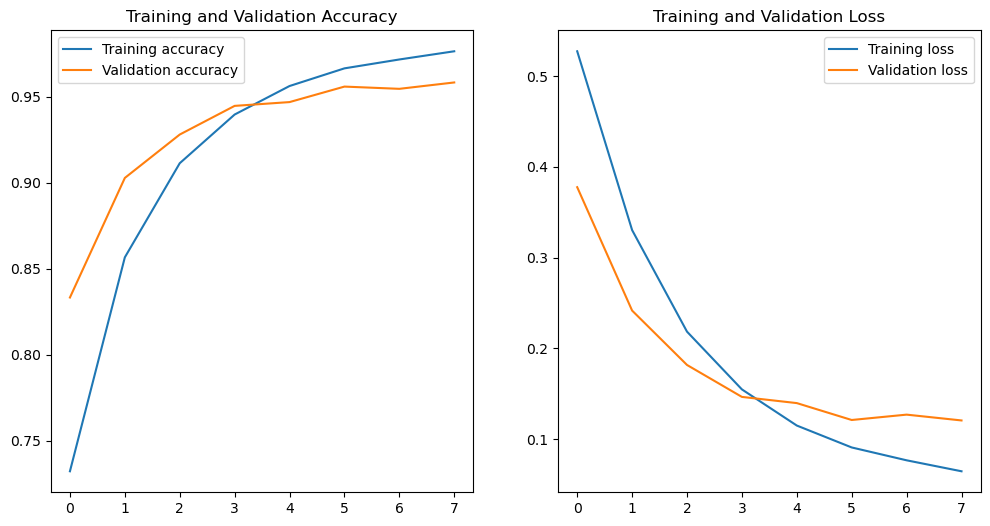

In [15]:
plot_history(history,8)

(200, 200, 3)


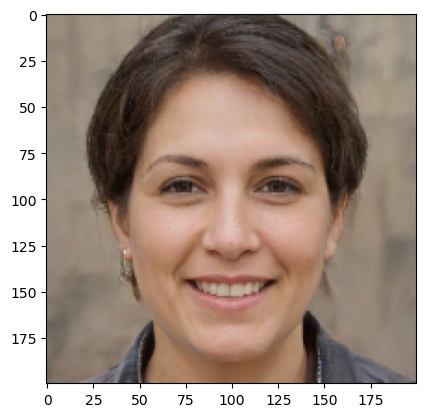

In [16]:
# total random image from the web
image_path = "./Face1.jpg"
image = process_image(image_path)
plt.imshow(image)
print(image.shape)

In [17]:
model.predict(np.array([image]))

1/1 [==============================] - 0s 285ms/step


array([[1.0573463e-17]], dtype=float32)

In [18]:
model.evaluate(data_test)

834/834 [==============================] - 6s 7ms/step - loss: 0.1218 - accuracy: 0.9589 - recall: 0.9563


[0.12181548774242401, 0.958899974822998, 0.9563000202178955]

# Conclusion
Mission done, model succesfuly recognise real faces and deepfake images with an accuracy of ~96%, so it's highly satisfying

In [ ]:
|